In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

file_path = "/HSBC_ST138D-XLS-ENG.xlsx"
df = pd.read_excel(file_path, sheet_name="Synthetic Data")

# Filter AGE
df = df[df['AGE'].isin(['18-24', '25-29', '30-34'])]

# Drop AGE (categorical) for clustering, but keep it for later interpretation
age_col = df['AGE']
df_numeric = df.drop(columns=['AGE'])

# Normalize
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)


             INCOME           TRB    DIG_ACTIVE      FX_TRANS        PAYME  \
count  5.000000e+04  5.000000e+04  50000.000000  50000.000000  50000.00000   
mean   3.123016e+04  1.627904e+05      0.818160      0.237360      0.66570   
std    2.589240e+04  3.917090e+05      0.385716      0.425469      0.47175   
min   -1.966988e+04  0.000000e+00      0.000000      0.000000      0.00000   
25%    1.855612e+04  4.681008e+03      1.000000      0.000000      0.00000   
50%    2.710790e+04  3.790828e+04      1.000000      0.000000      1.00000   
75%    3.986781e+04  1.703579e+05      1.000000      0.000000      1.00000   
max    1.380715e+06  2.282008e+07      1.000000      1.000000      1.00000   

                CC            LN            MT            TD            SC  \
count  50000.00000  50000.000000  50000.000000  50000.000000  50000.000000   
mean       0.48838      0.076440      0.077520      0.093200      0.096360   
std        0.49987      0.265703      0.267417      0.290715   

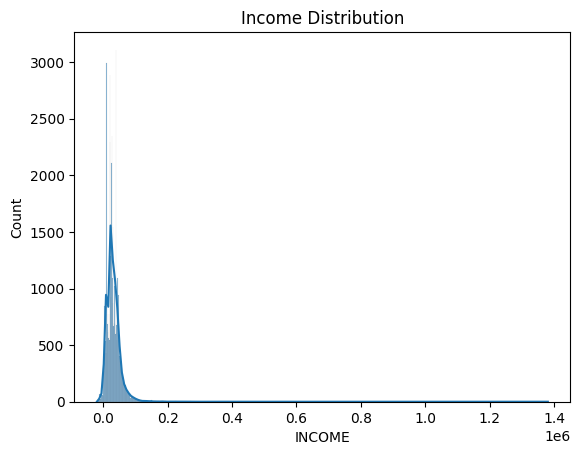

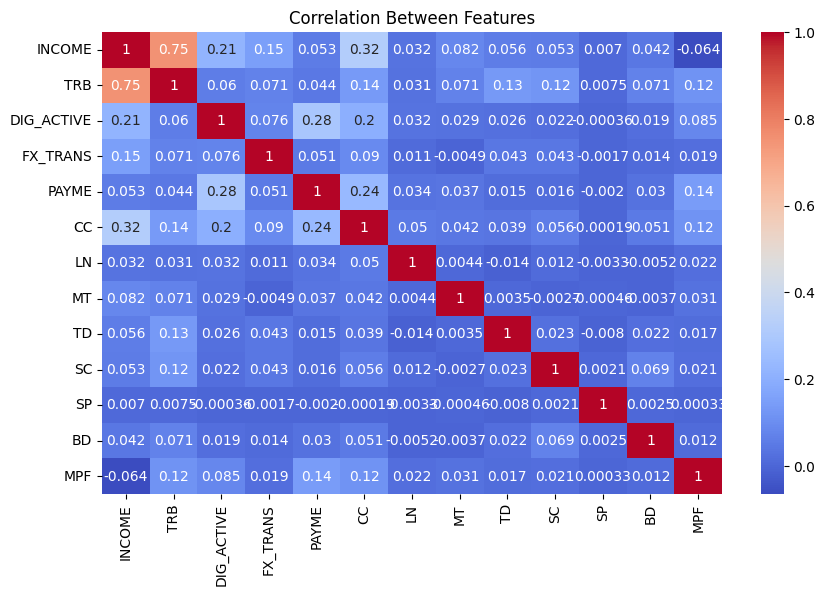

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Summary
print(df.describe())

# Distribution of income
sns.histplot(df['INCOME'], kde=True)
plt.title("Income Distribution")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
# Calculate correlation on numeric columns only
numeric_df = df.select_dtypes(include=['number']) # Select only numeric columns for correlation
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Features")
plt.show()

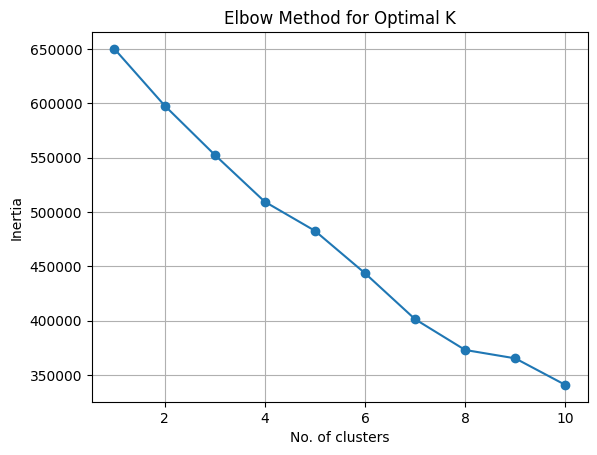

In [8]:
from sklearn.cluster import KMeans
import numpy as np

# Elbow Method
inertia = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('No. of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()




In [10]:
# optimal k = 4
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(df_scaled)
df['Cluster'] = clusters

In [14]:
# Add age back
df['AGE'] = age_col

# Mean profile of each cluster, excluding non-numeric columns like 'AGE'
cluster_profile = df.groupby('Cluster').agg({col: 'mean' for col in df.select_dtypes(include=['number']).columns})
# Use agg to specify 'mean' for numeric columns only. This avoids trying to calculate the mean of 'AGE'

print(cluster_profile)

               INCOME            TRB  DIG_ACTIVE  FX_TRANS     PAYME  \
Cluster                                                                
0        33728.523728  267801.907356    0.835771  0.287144  0.676161   
1        29709.699652  121616.170340    0.808562  0.223684  0.657027   
2        39782.156332  391275.815599    0.847649  0.295886  0.683318   
3        33853.733930  199259.296058    0.861264  0.254393  0.720692   

               CC        LN        MT        TD        SC        SP        BD  \
Cluster                                                                         
0        0.558891  0.000000  0.076726  0.000000  1.000000  0.048755  0.121375   
1        0.465880  0.000000  0.076876  0.000000  0.000000  0.050943  0.064623   
2        0.544756  0.002034  0.080470  0.987342  0.114828  0.043852  0.089286   
3        0.574351  1.000000  0.081301  0.076580  0.108314  0.047469  0.066352   

              MPF  Cluster  
Cluster                     
0        0.317167     

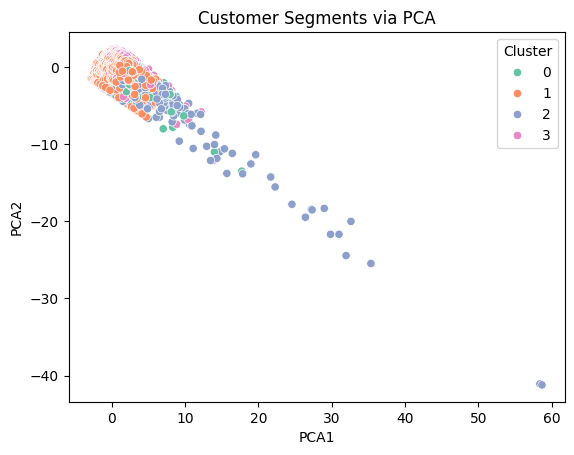

In [16]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='Set2')
plt.title("Customer Segments via PCA")
plt.show()

In [17]:
from sklearn.metrics import silhouette_score

score = silhouette_score(df_scaled, df['Cluster'])
print(f"Silhouette Score: {score:.2f}")


Silhouette Score: 0.26


In [19]:
for k in [2, 4, 6]:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    print(f"Silhouette score for k={k}: {score:.2f}")


Silhouette score for k=2: 0.27
Silhouette score for k=4: 0.26
Silhouette score for k=6: 0.28


In [21]:
for k in [2, 4, 8]:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    print(f"Silhouette score for k={k}: {score:.2f}")

Silhouette score for k=2: 0.27
Silhouette score for k=4: 0.26
Silhouette score for k=8: 0.20


In [27]:
print('cluster quality of 6 clusters is the best since the silhouette score of it is highest')
print('Real-World Implications for HSBC')
print('Cluster 1: High TRB & Income → Priority customers → Recommend premium investment products.')
print('Cluster 2: Young, digitally active → Promote digital wallet, FX services.')
print('Cluster 3: Loan-heavy profile → Offer consolidation plans or MPF promotions.')

cluster quality of 6 clusters is the best since the silhouette score of it is highest
Real-World Implications for HSBC
Cluster 1: High TRB & Income → Priority customers → Recommend premium investment products.
Cluster 2: Young, digitally active → Promote digital wallet, FX services.
Cluster 3: Loan-heavy profile → Offer consolidation plans or MPF promotions.


In [28]:
# Clone the existing dataset without AGE for feature engineering
df_features = df_numeric.copy()


In [29]:
# Define the binary product columns
product_columns = ['FX_TRANS', 'PAYME', 'CC', 'LN', 'MT', 'TD', 'SC', 'SP', 'BD', 'MPF']

# Sum up product indicators for each customer
df_features['PRODUCT_COUNT'] = df_features[product_columns].sum(axis=1)


In [30]:
# Avoid divide-by-zero errors by adding 1 to income
df_features['TRB_INCOME_RATIO'] = df_features['TRB'] / (df_features['INCOME'] + 1)


In [31]:
from sklearn.preprocessing import StandardScaler

# Scale all features to have mean 0 and standard deviation 1
scaler = StandardScaler()
df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)


In [32]:
# See the first few rows of new features
print(df_features[['PRODUCT_COUNT', 'TRB_INCOME_RATIO']].head())


   PRODUCT_COUNT  TRB_INCOME_RATIO
0              2          6.884567
1              1          0.000092
2              0          6.377768
3              1          0.003073
4              1          0.069997


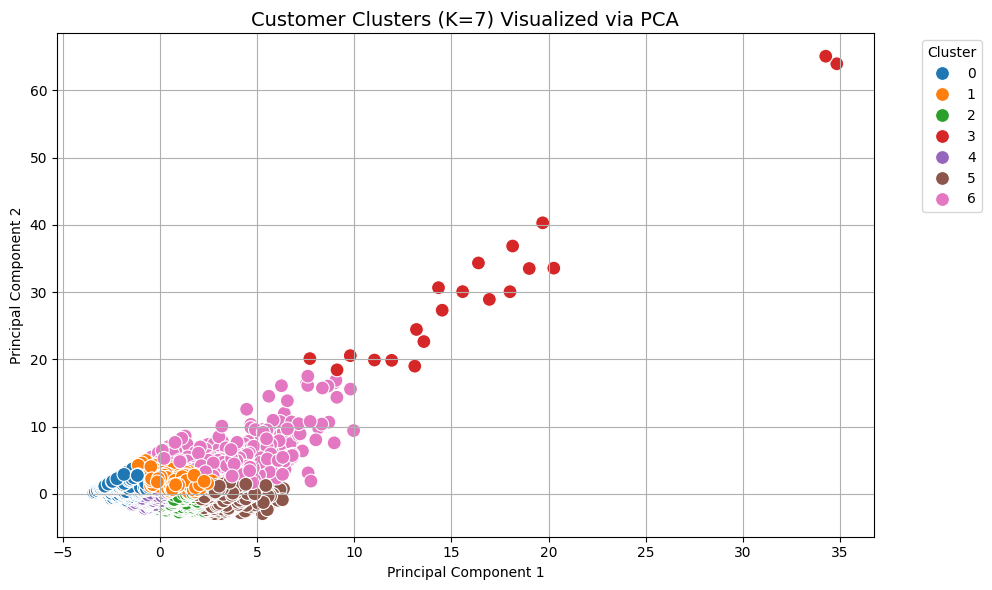

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# --- Step 1: Feature Engineering ---
product_columns = ['FX_TRANS', 'PAYME', 'CC', 'LN', 'MT', 'TD', 'SC', 'SP', 'BD', 'MPF']
df_features = df_numeric.copy()
df_features['PRODUCT_COUNT'] = df_features[product_columns].sum(axis=1)
df_features['TRB_INCOME_RATIO'] = df_features['TRB'] / (df_features['INCOME'] + 1)

# --- Step 2: Normalize Data ---
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

# --- Step 3: Dimensionality Reduction (PCA) ---
pca = PCA(n_components=2)  # 2 components for plotting
df_pca = pca.fit_transform(df_scaled)

# --- Step 4: Apply KMeans Clustering ---
kmeans = KMeans(n_clusters=7, random_state=42)
cluster_labels = kmeans.fit_predict(df_pca)

# --- Step 5: Create DataFrame for Visualization ---
pca_df = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = cluster_labels

# --- Step 6: Plot the Clusters ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100)
plt.title("Customer Clusters (K=7) Visualized via PCA", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
from sklearn.metrics import silhouette_score

# Assuming you already performed KMeans clustering and have cluster labels
# cluster_labels = kmeans.fit_predict(df_pca)

# Calculate Silhouette Score using PCA-reduced features
score = silhouette_score(df_pca, cluster_labels)

# Print the result
print(f"Silhouette Score for K=7: {score:.3f}")


Silhouette Score for K=7: 0.376


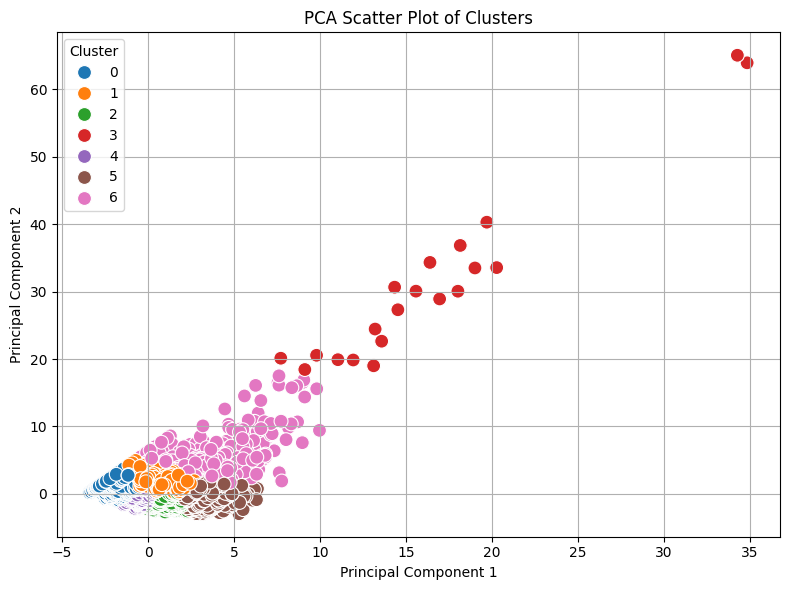

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- Assume df_features has already been created with engineered features ---

# Step 1: Normalize
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

# Step 2: PCA for 2D projection
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Step 3: KMeans Clustering
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(df_pca)

# Step 4: Prepare DataFrame for plotting
pca_df = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters

# Step 5: Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100)
plt.title("PCA Scatter Plot of Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


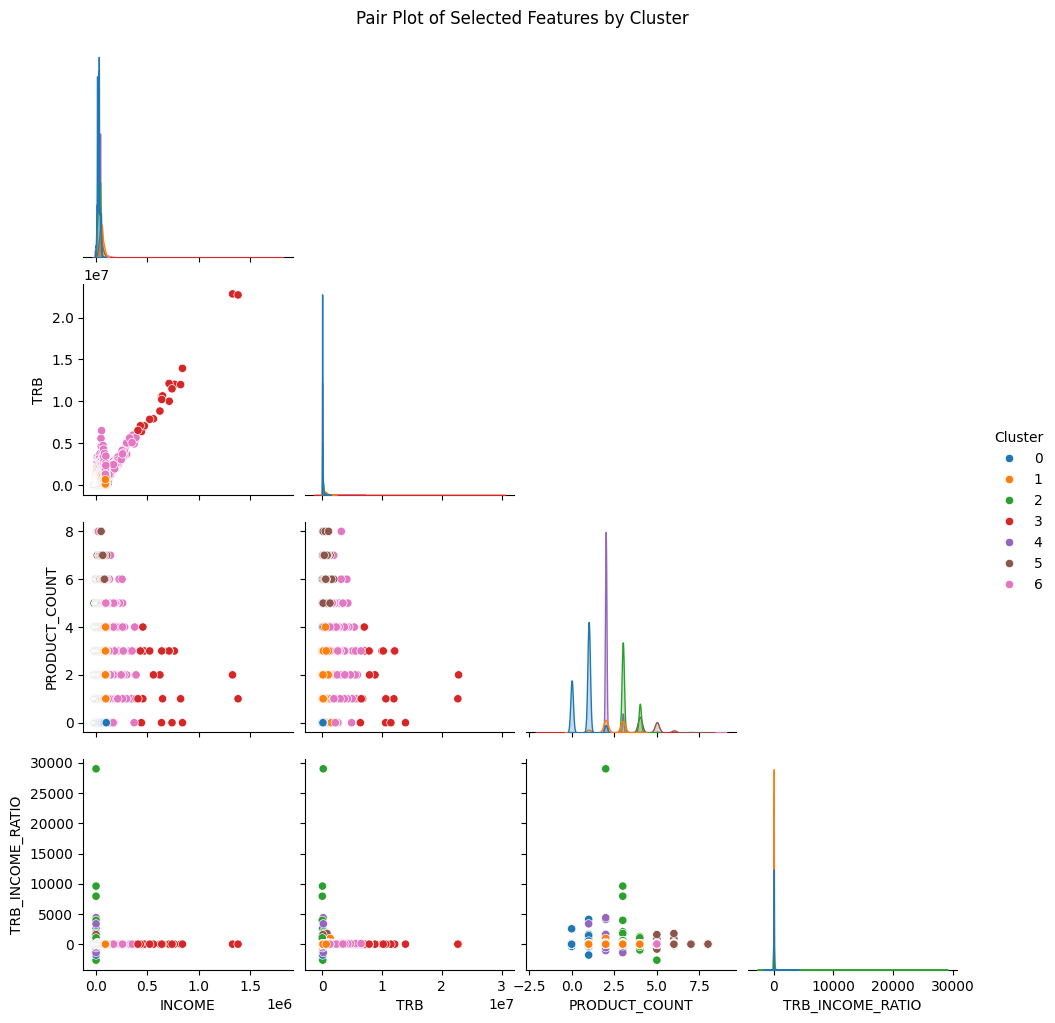

In [36]:
# Add cluster labels to original features DataFrame
df_pairplot = df_features.copy()
df_pairplot['Cluster'] = clusters

# Optional: Choose a subset of features for clarity in plots
selected_features = ['INCOME', 'TRB', 'PRODUCT_COUNT', 'TRB_INCOME_RATIO', 'Cluster']

# Plot pairplot
sns.pairplot(df_pairplot[selected_features], hue='Cluster', palette='tab10', corner=True)
plt.suptitle("Pair Plot of Selected Features by Cluster", y=1.02)
plt.show()
